## BAYESIAN INFERENCE AND DATA ANALYSIS TECHNIQUES - [ISABELA PEREIRA LIMA DIAS](https://github.com/isadays/BayesianInference/tree/main/Clinical%20Trials)

##### Global tuberculosis report cover: WHO has published a global tuberculosis (TB) report every year since 1997.The report provides a comprehensive and up-to-date assessment of the TB epidemic, and of progress in prevention, diagnosis and treatment of the disease at global, regional and country levels.




References: https://www.who.int/teams/global-tuberculosis-programme/data AND https://www.kaggle.com/datasets/mpwolke/cusersmarildownloadstreatmentcsv




In [66]:
try:
  import google.colab
  !{sys.executable} -m pip -q -q install pycm
except:
  pass

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd
import sys
import seaborn as sns

Context
Data provided by countries to WHO and estimates of TB burden generated by WHO for the Global Tuberculosis Report

In [67]:
#Import the dataset
df = pd.read_csv('treatment.csv', sep=';')

To me, the optimal approach to initiate a data analysis is by addressing missing values first. This step enables us to discern the statistical significance of parameters, which is crucial for our analysis.


In [69]:
# Calculate the total number of missing values in each column
missing_values = df.isnull().sum()

# Calculate the total number of values in each column
total_values = df.shape[0]

# Calculate the percentage of missing values in each column
percentage_missing = (missing_values / total_values) * 100

# Create a DataFrame to display the percentage of missing values
missing_data = pd.DataFrame({'Column': df.columns, 'Percentage Missing': percentage_missing})

missing_data_sorted = missing_data.sort_values(by='Percentage Missing',ascending=False)

print(missing_data_sorted)

                              Column  Percentage Missing
Unnamed: 72              Unnamed: 72           99.530241
hiv_ret_fail            hiv_ret_fail           86.788021
hiv_new_snep_fail  hiv_new_snep_fail           86.631435
hiv_ret_cur              hiv_ret_cur           86.533568
hiv_ret_def              hiv_ret_def           86.455275
...                              ...                 ...
g_whoregion              g_whoregion            0.000000
iso3                            iso3            0.000000
iso_numeric              iso_numeric            0.000000
year                            year            0.000000
country                      country            0.000000

[73 rows x 2 columns]




- Columns with Low Missing Values (e.g., less than 20%):

For columns with relatively few missing values, you might consider imputation methods such as mean, median, mode imputation, or using more sophisticated methods like KNN imputation or interpolation.

- Columns with Moderate Missing Values (e.g., between 20% and 50%):

For columns with a moderate percentage of missing values, you could use more advanced imputation methods like KNN imputation, iterative imputation (e.g., MICE), or consider building predictive models to estimate missing values based on other features.

- Columns with High Missing Values (e.g., over 50%):

Columns with a high percentage of missing values may require careful consideration. Depending on the importance of these columns to your analysis, you might decide to drop them if they are not critical.

In [70]:
# Drop columns with over 50% missing values
columns_to_drop = missing_data[missing_data['Percentage Missing'] > 50]['Column']
df_cleaned = df.drop(columns_to_drop, axis=1)

# Print the remaining columns
print("Remaining columns after dropping columns with over 50% missing values:")
print(df_cleaned.columns)


Remaining columns after dropping columns with over 50% missing values:
Index(['country', 'iso2', 'iso3', 'iso_numeric', 'g_whoregion', 'year',
       'rep_meth', 'new_sp_coh', 'new_sp_cur', 'new_sp_cmplt', 'new_sp_died',
       'new_sp_fail', 'new_sp_def', 'c_new_sp_tsr', 'c_new_tsr', 'c_ret_tsr'],
      dtype='object')


- 'country': Name of the country.

- 'iso2': ISO 3166-1 alpha-2 country code (two-letter country code).
- 'iso3': ISO 3166-1 alpha-3 country code (three-letter country code).
- 'iso_numeric': ISO 3166-1 numeric country code (numeric country code).
- 'g_whoregion': WHO region to which the country belongs.
- 'year': Year of the data.
- 'rep_meth': Method of confirmation used to report treatment outcomes of pulmonary cases.
- 'new_sp_coh': Outcomes for new pulmonary smear-positive (and/or culture-positive) cases: cohort size.
- 'new_sp_cur': Outcomes for new pulmonary smear-positive (and/or culture-positive) cases: cured.
- 'new_sp_cmplt': Outcomes for new pulmonary smear-positive (and/or culture-positive) cases: completed.
- 'new_sp_died': Outcomes for new pulmonary smear-positive (and/or culture-positive) cases: died.
- 'new_sp_fail': Outcomes for new pulmonary smear-positive (and/or culture-positive) cases: failed.
- 'new_sp_def': Outcomes for new pulmonary smear-positive (and/or culture-positive) cases: defaulted.
- 'c_new_sp_tsr': Treatment success rate for new pulmonary smear-positive (and/or culture-positive) cases, percent.
- 'c_new_tsr': Treatment success rate for all new cases (including relapse cases if rel_with_new_flg = 1), percent.
- 'c_ret_tsr': Treatment success rate for re-treatment cases (excluding relapse cases if rel_with_new_flg = 1), percent.

In [71]:
df_cleaned.head()

,country,iso2,iso3,iso_numeric,g_whoregion,year,rep_meth,new_sp_coh,new_sp_cur,new_sp_cmplt,new_sp_died,new_sp_fail,new_sp_def,c_new_sp_tsr,c_new_tsr,c_ret_tsr
0,Afghanistan,AF,AFG,4,EMR,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AF,AFG,4,EMR,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AF,AFG,4,EMR,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AF,AFG,4,EMR,1997,100.0,2001.0,786.0,108.0,33.0,22.0,164.0,45.0,45.0,NaN
4,Afghanistan,AF,AFG,4,EMR,1998,100.0,2913.0,772.0,199.0,48.0,23.0,168.0,33.0,33.0,78.0


First : K-NN imputer: Filling the missing values

To deal with a moderate percentage of missing values (e.g., between 20% and 50%), we can use more advanced imputation methods such as KNN imputation, iterative imputation (e.g., MICE).

KNNImputer is a data transform that is first configured based on the method used to estimate the missing values.

The default distance measure is a Euclidean distance measure that is NaN aware, e.g. will not include NaN values when calculating the distance between members of the training dataset. This is set via the “metric” argument.

The number of neighbors is set to five by default and can be configured by the “n_neighbors” argument.

Finally, the distance measure can be weighed proportional to the distance between instances (rows), although this is set to a uniform weighting by default, controlled via the “weights” argument.

In [72]:
from sklearn.impute import KNNImputer

# Extract columns with moderate missing values from cleaned dataset
columns_to_impute = missing_data[(missing_data['Percentage Missing'] <= 50)]['Column']

# Extract numerical columns among columns to impute
numerical_columns_to_impute = df_cleaned[columns_to_impute].select_dtypes(include=['number']).columns

# Get indices of numerical columns to impute
ix = [df_cleaned.columns.get_loc(col) for col in numerical_columns_to_impute]

# Extract numerical data for imputation
X = df_cleaned[numerical_columns_to_impute].values

# Create KNNImputer and fit it on numerical data
imputer = KNNImputer()
imputer.fit(X)

# Transform the dataset using KNN imputation
X_imputed = imputer.transform(X)

# Replace original numerical columns with imputed values
df_cleaned[numerical_columns_to_impute] = X_imputed


<Axes: >

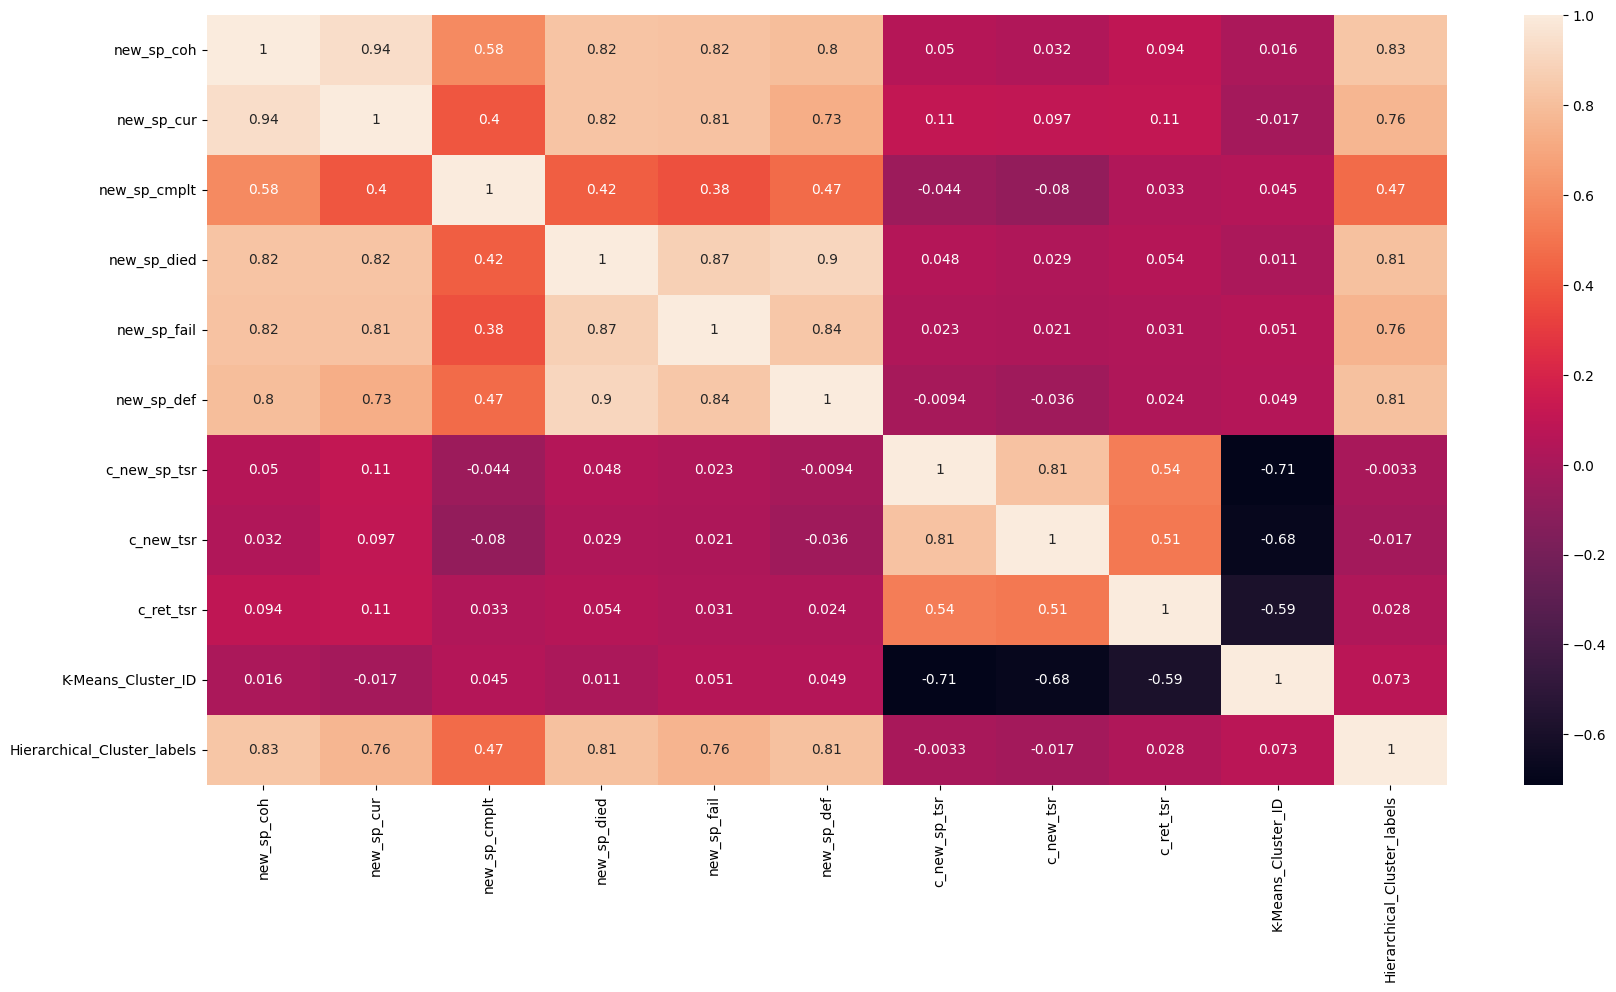

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(df_cleaned.corr(),annot = True)

Significant correlations:
- new_sp_coh and new_sp_cur
- new_sp_coh abd new_sp_died
- new_sp_coh and new_sp_fail
- new_sp_coh and new_sp_def
-new_sp_fail and new_sp_def


From this, we elminate the variable rep_meth

**Note**: This approach may lack significance as there is no assurance that all the data shares the same units. Hence, to ensure a more meaningful analysis, employing standardscaler and PCA (Principal Component Analysis) is essential and stan.

The purpose of StandardScaler in sklearn.preprocessing is to standardize features by removing the mean and scaling them to unit variance. This is a common preprocessing step in machine learning workflows, especially when working with algorithms that assume data to be centered around zero and have a variance of 1, such as many linear models, SVMs, and neural networks.

The StandardScaler transforms the data such that each feature has a mean of 0 and a standard deviation of 1. This is achieved by subtracting the mean of the feature and then dividing by the standard deviation.

In [75]:
# Standardization of the dataset before performing PCA
from sklearn.preprocessing import StandardScaler
#Drop the categorical variables (they have no significant corr)
df_cleaned = df_cleaned.drop(columns=['country',	'iso2',	'iso3',	'iso_numeric',	'g_whoregion',	'year'])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned)


In [76]:
data_scaled_df = pd.DataFrame(data_scaled,columns=df_cleaned.columns)

<Axes: >

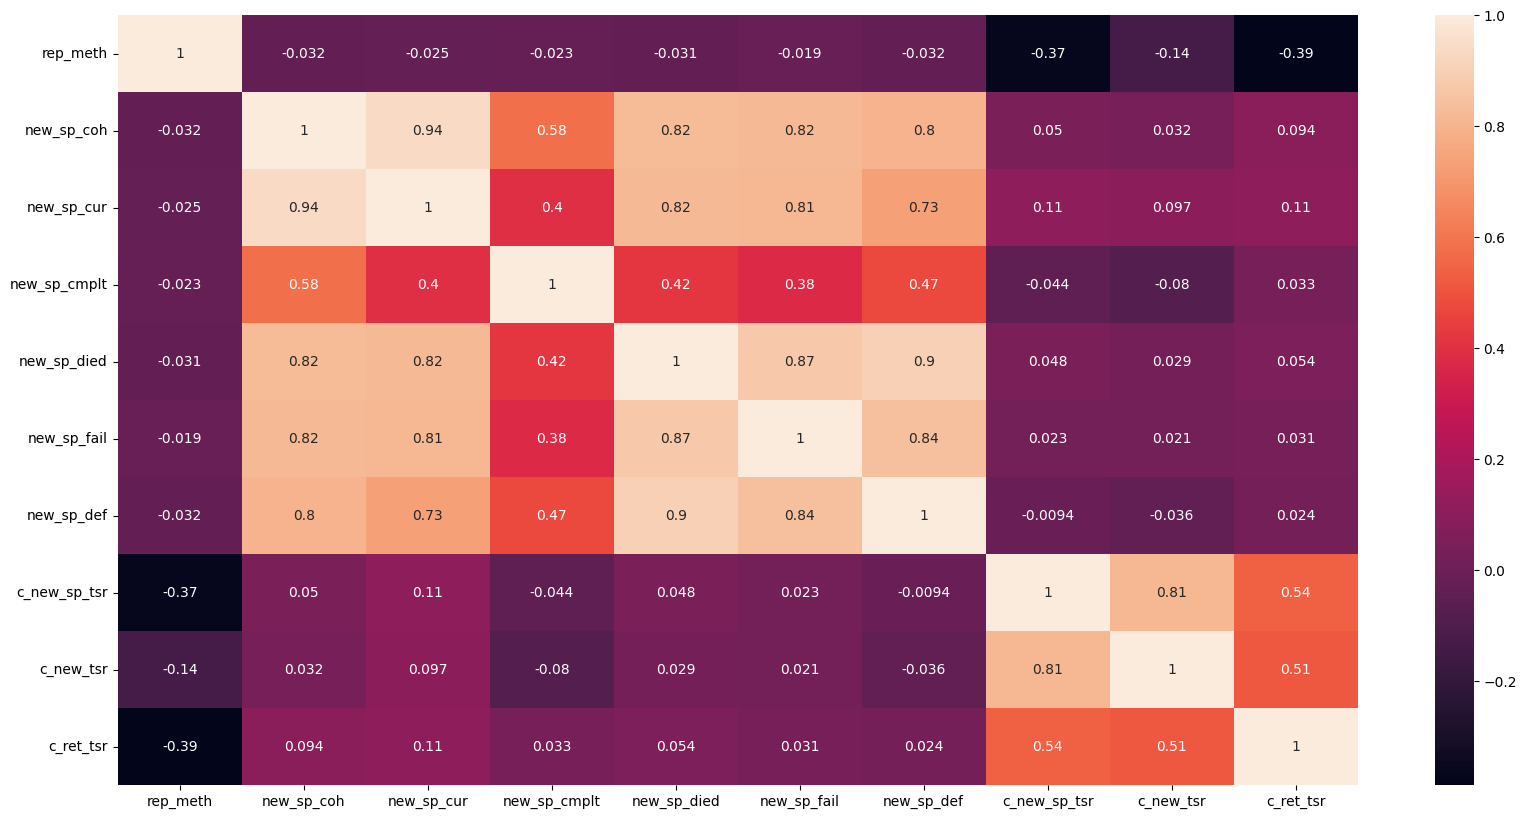

In [78]:
plt.figure(figsize = (20,10))
sns.heatmap(data_scaled_df.corr(),annot = True)

Principal Component Analysis (PCA) is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while preserving most of the original information. It achieves this by identifying the directions, called principal components, along which the data varies the most.


Note: While we have already established the reduced dimensions through an analysis of the percentage of NaN values, in this particular step, our focus lies solely on applying the method rather than revisiting those previous results.







In [79]:
# Import the PCA module from sklearn.decomposition
from sklearn.decomposition import PCA

# Create an instance of PCA with a specified random state for reproducibility
pca = PCA(random_state=42)

# Fit the PCA model to the scaled data
pca.fit(data_scaled)


PCA(random_state=42)

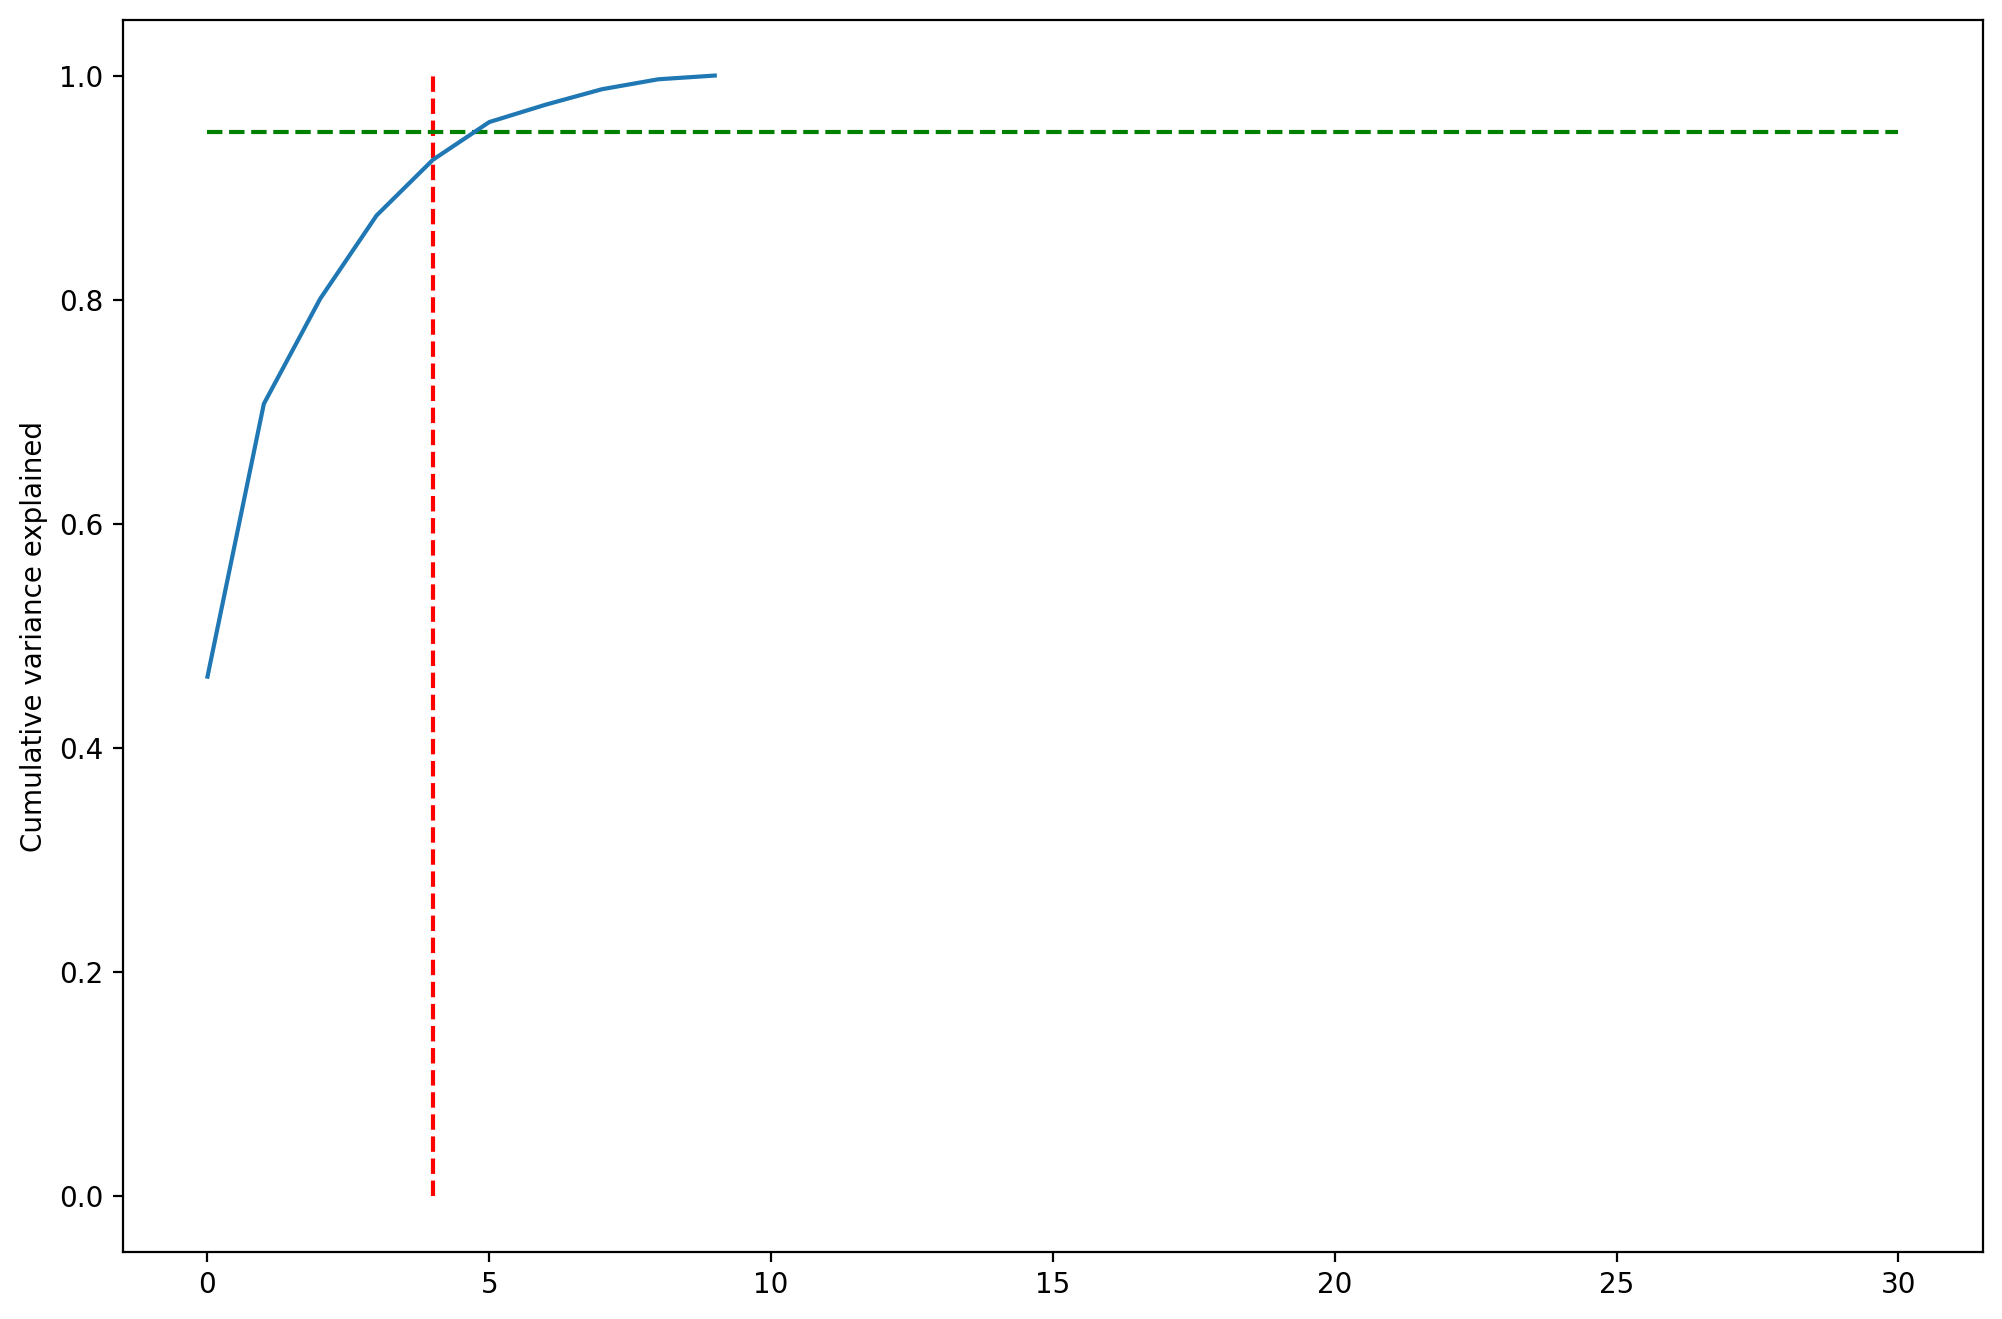

In [80]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8],dpi=200)
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Performing PCA with 4 components

In [81]:
# Import the IncrementalPCA module from sklearn.decomposition
from sklearn.decomposition import IncrementalPCA

# Create an instance of IncrementalPCA with the desired number of components
pca_final = IncrementalPCA(n_components=4)

# Fit the IncrementalPCA model to the scaled data and transform it to the lower-dimensional space
data_pca_final = pca_final.fit_transform(data_scaled)

# Print the shape of the original DataFrame and the shape of the data after PCA transformation
print(df_cleaned.shape)  # Print the shape of the original DataFrame
print(data_pca_final.shape)  # Print the shape of the data after PCA transformation


(5109, 10)
(5109, 4)


<Axes: >

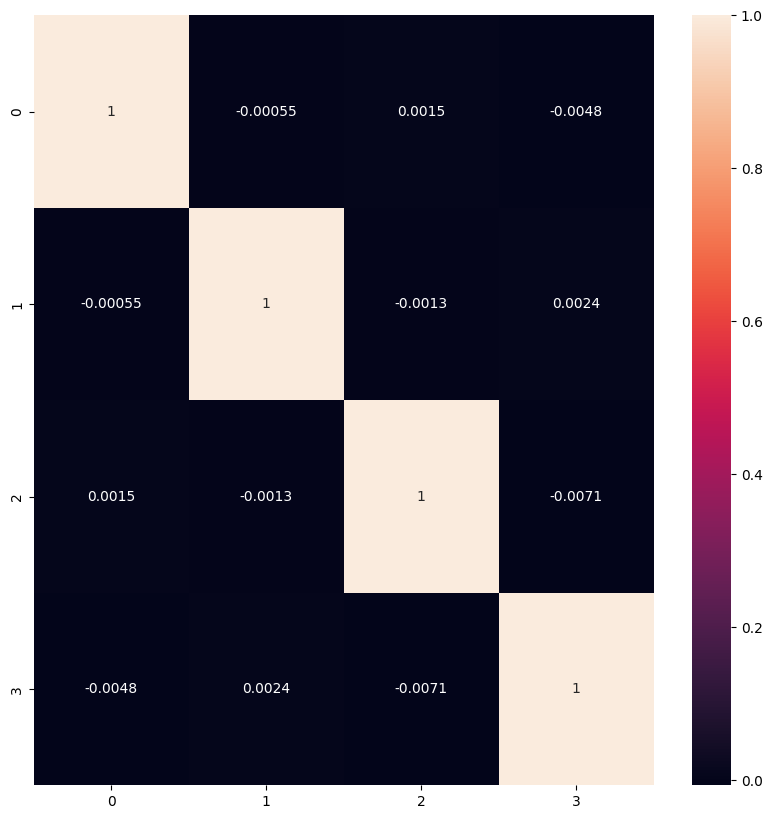

In [82]:
# Calculate the correlation matrix of the PCA-transformed data
corrmat = np.corrcoef(data_pca_final.transpose())

# Create a figure for plotting with a specified size
plt.figure(figsize=[10,10])

# Plot the heatmap of the correlation matrix using seaborn
sns.heatmap(corrmat, annot=True)


Clustering is a technique used in unsupervised machine learning to group similar data points together based on certain features or characteristics. The primary goal of clustering is to partition a dataset into distinct groups, or clusters, such that data points within the same cluster are more similar to each other than they are to those in other clusters. Clustering is commonly used for exploratory data analysis, pattern recognition, and data compression.


In [83]:
# Import the KMeans clustering algorithm from scikit-learn
from sklearn.cluster import KMeans

# Import the silhouette_score metric from scikit-learn
from sklearn.metrics import silhouette_score

# Import the linkage, dendrogram, and cut_tree functions from scipy.cluster.hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

# Instantiate a KMeans object with a specified number of clusters
kmeans = KMeans(n_clusters=5, max_iter=1000)

# Fit the KMeans model to the PCA-transformed data
kmeans.fit(data_pca_final)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=1000, n_clusters=5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

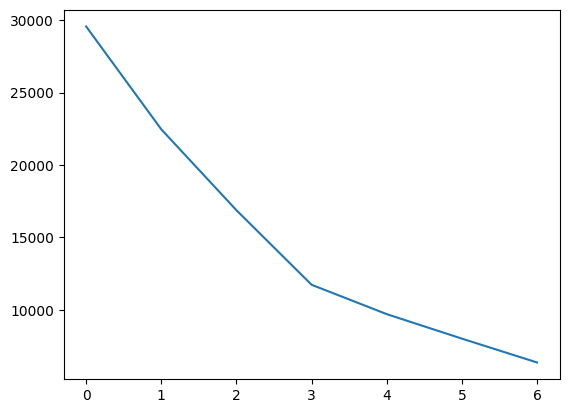

In [84]:
# Create an empty list to store the sum of squared distances (SSD) for each number of clusters
ssd = []

# Define a range of cluster numbers to iterate over
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Iterate over each number of clusters
for num_clusters in range_n_clusters:
    # Instantiate a KMeans object with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)

    # Fit the KMeans model to the PCA-transformed data
    kmeans.fit(data_pca_final)

    # Append the inertia (SSD) of the fitted model to the SSD list
    ssd.append(kmeans.inertia_)

# Plot the SSDs for each number of clusters
plt.plot(ssd)

In [85]:
# Define a range of cluster numbers to iterate over
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Iterate over each number of clusters
for num_clusters in range_n_clusters:

    # Instantiate a KMeans object with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)

    # Fit the KMeans model to the PCA-transformed data
    kmeans.fit(data_pca_final)

    # Assign cluster labels to each data point
    cluster_labels = kmeans.labels_

    # Calculate the silhouette score for the current clustering configuration
    silhouette_avg = silhouette_score(data_pca_final, cluster_labels)

    # Print the silhouette score for the current number of clusters
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.9167992237359137


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.5544162039911742


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.5671821399814111


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.5112029844746375


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.39887065628448176


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.42483984136955616


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.42647714045771606


In [86]:
# Define the final model with the desired number of clusters (k=3)
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42)

# Fit the final KMeans model to the PCA-transformed data
kmeans.fit(data_pca_final)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=1000, n_clusters=3, random_state=42)

In [87]:
# Assign cluster labels obtained from KMeans clustering to a new column in the cleaned DataFrame
df_cleaned['K-Means_Cluster_ID'] = kmeans.labels_

Hierarchical clustering is a clustering technique that builds a hierarchy of clusters by either iteratively merging smaller clusters into larger ones (agglomerative) or by recursively splitting the data into smaller clusters (divisive). Two common linkage criteria used in hierarchical clustering are single linkage and complete linkage.



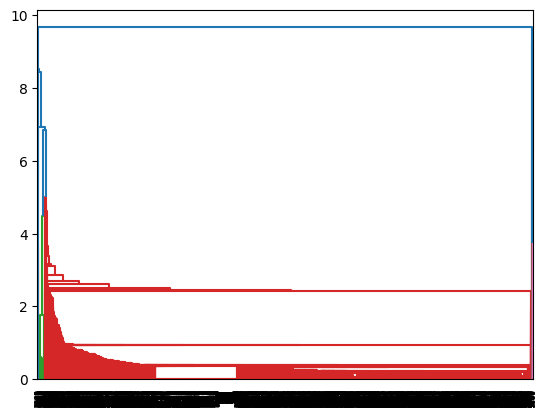

In [88]:
# Perform hierarchical clustering using single linkage
sl_mergings = linkage(data_scaled_df, method="single", metric='euclidean')

# Plot the dendrogram
dendrogram(sl_mergings)

# Display the dendrogram plot
plt.show()

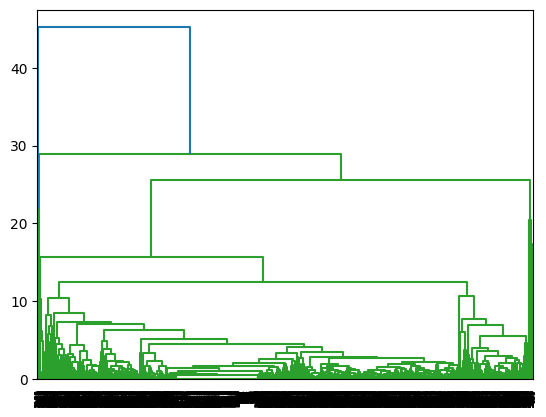

In [89]:
# Perform hierarchical clustering using complete linkage
cl_mergings = linkage(data_scaled_df, method="complete", metric='euclidean')

# Plot the dendrogram
dendrogram(cl_mergings)

# Display the dendrogram plot
plt.show()


In [94]:
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=4)


In [101]:
# Create a DataFrame from the PCA-transformed data with labeled principal components
data_pca_final_df = pd.DataFrame(data_pca_final, columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [103]:
# Assign cluster labels from KMeans and hierarchical clustering to new columns in the DataFrame
data_pca_final_df['K_Means_Cluster_ID'] = kmeans.labels_
data_pca_final_df['Hierarchical_Cluster_Labels'] = cl_cluster_labels
df_cleaned['Hierarchical_Cluster_Labels'] = cl_cluster_labels

<Axes: xlabel='PC1', ylabel='PC2'>

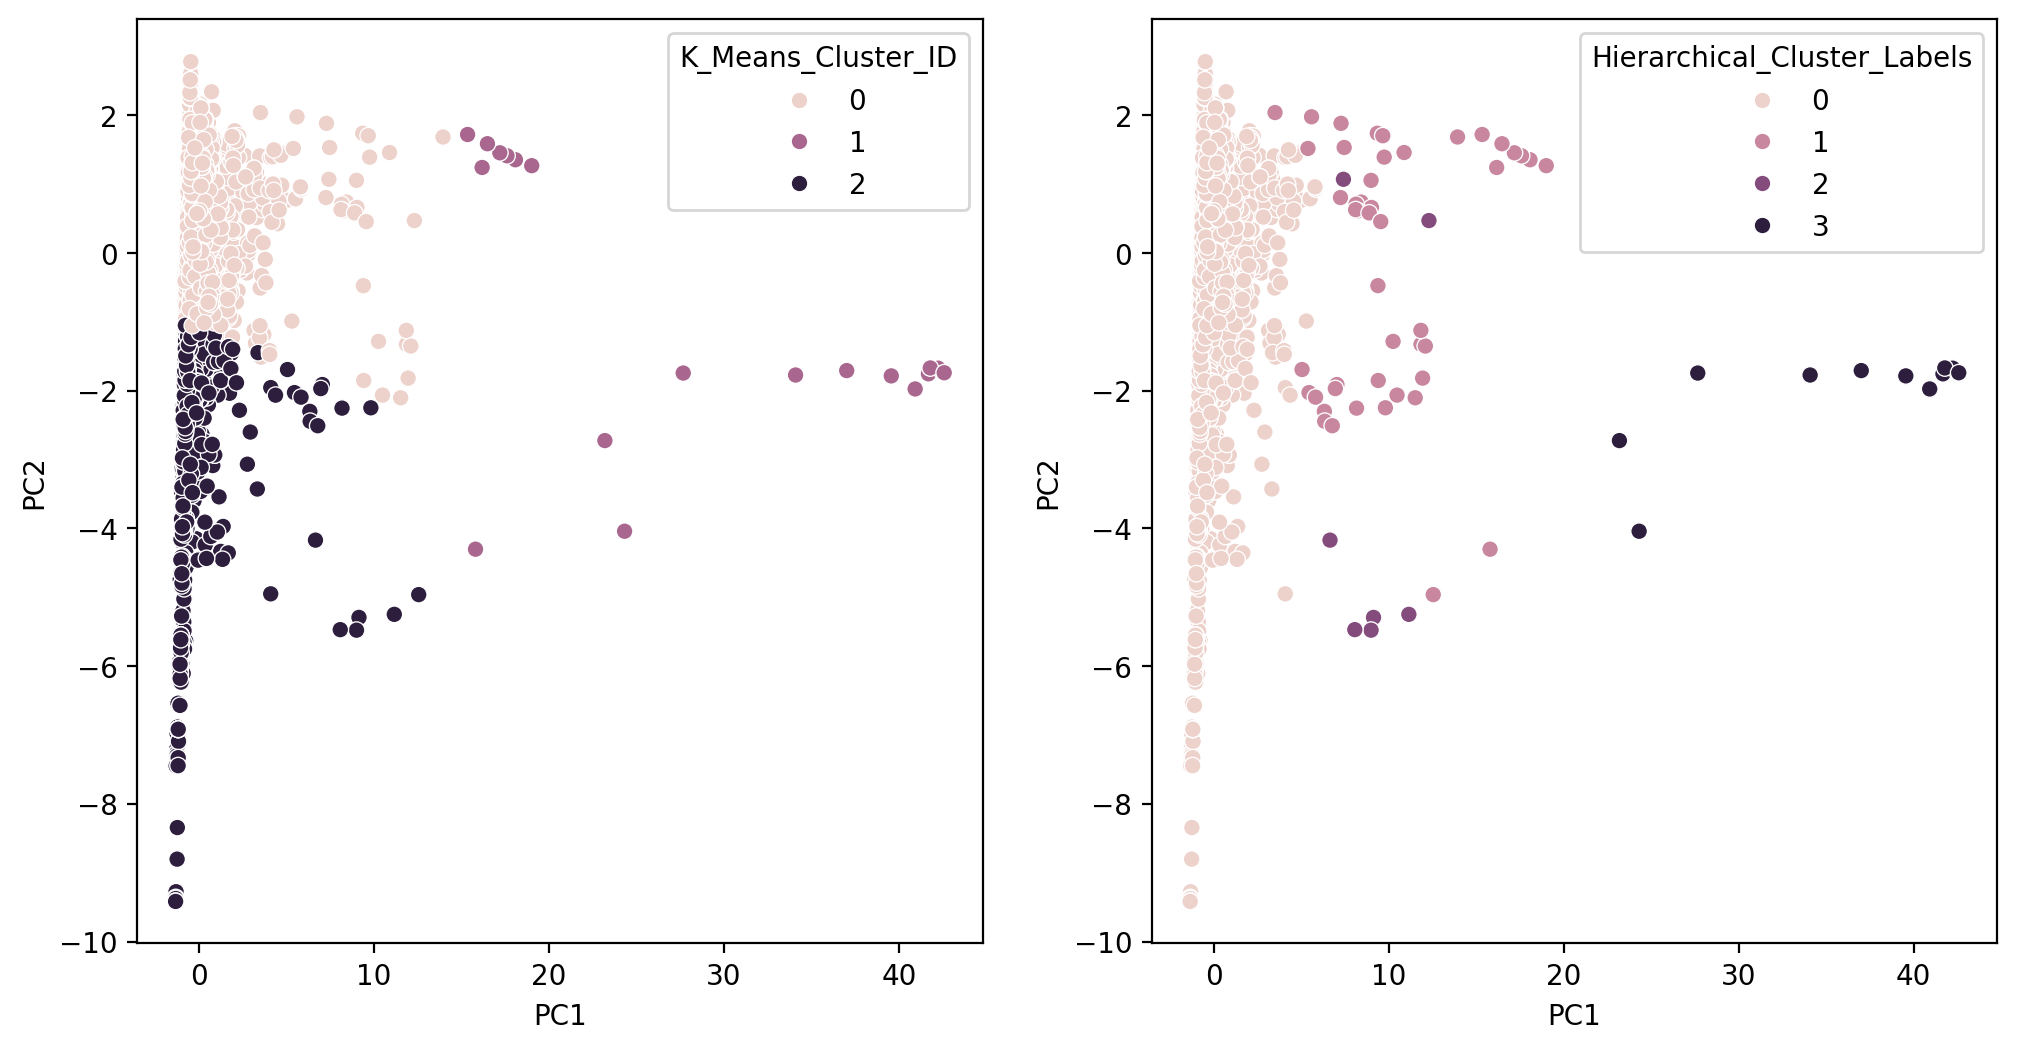

In [97]:
# Create a scatter plot using the first two principal components to visualize the cluster distribution

# Set up the figure and subplots
plt.figure(figsize=(12, 6), dpi=200)
plt.subplot(1, 2, 1)

# Scatter plot using KMeans cluster labels
sns.scatterplot(x='PC1', y='PC2', data=data_pca_final_df, hue='K_Means_Cluster_ID')

# Set up the second subplot
plt.subplot(1, 2, 2)

# Scatter plot using hierarchical cluster labels
sns.scatterplot(x='PC1', y='PC2', data=data_pca_final_df, hue='Hierarchical_Cluster_Labels')


<Axes: xlabel='new_sp_fail', ylabel='new_sp_died'>

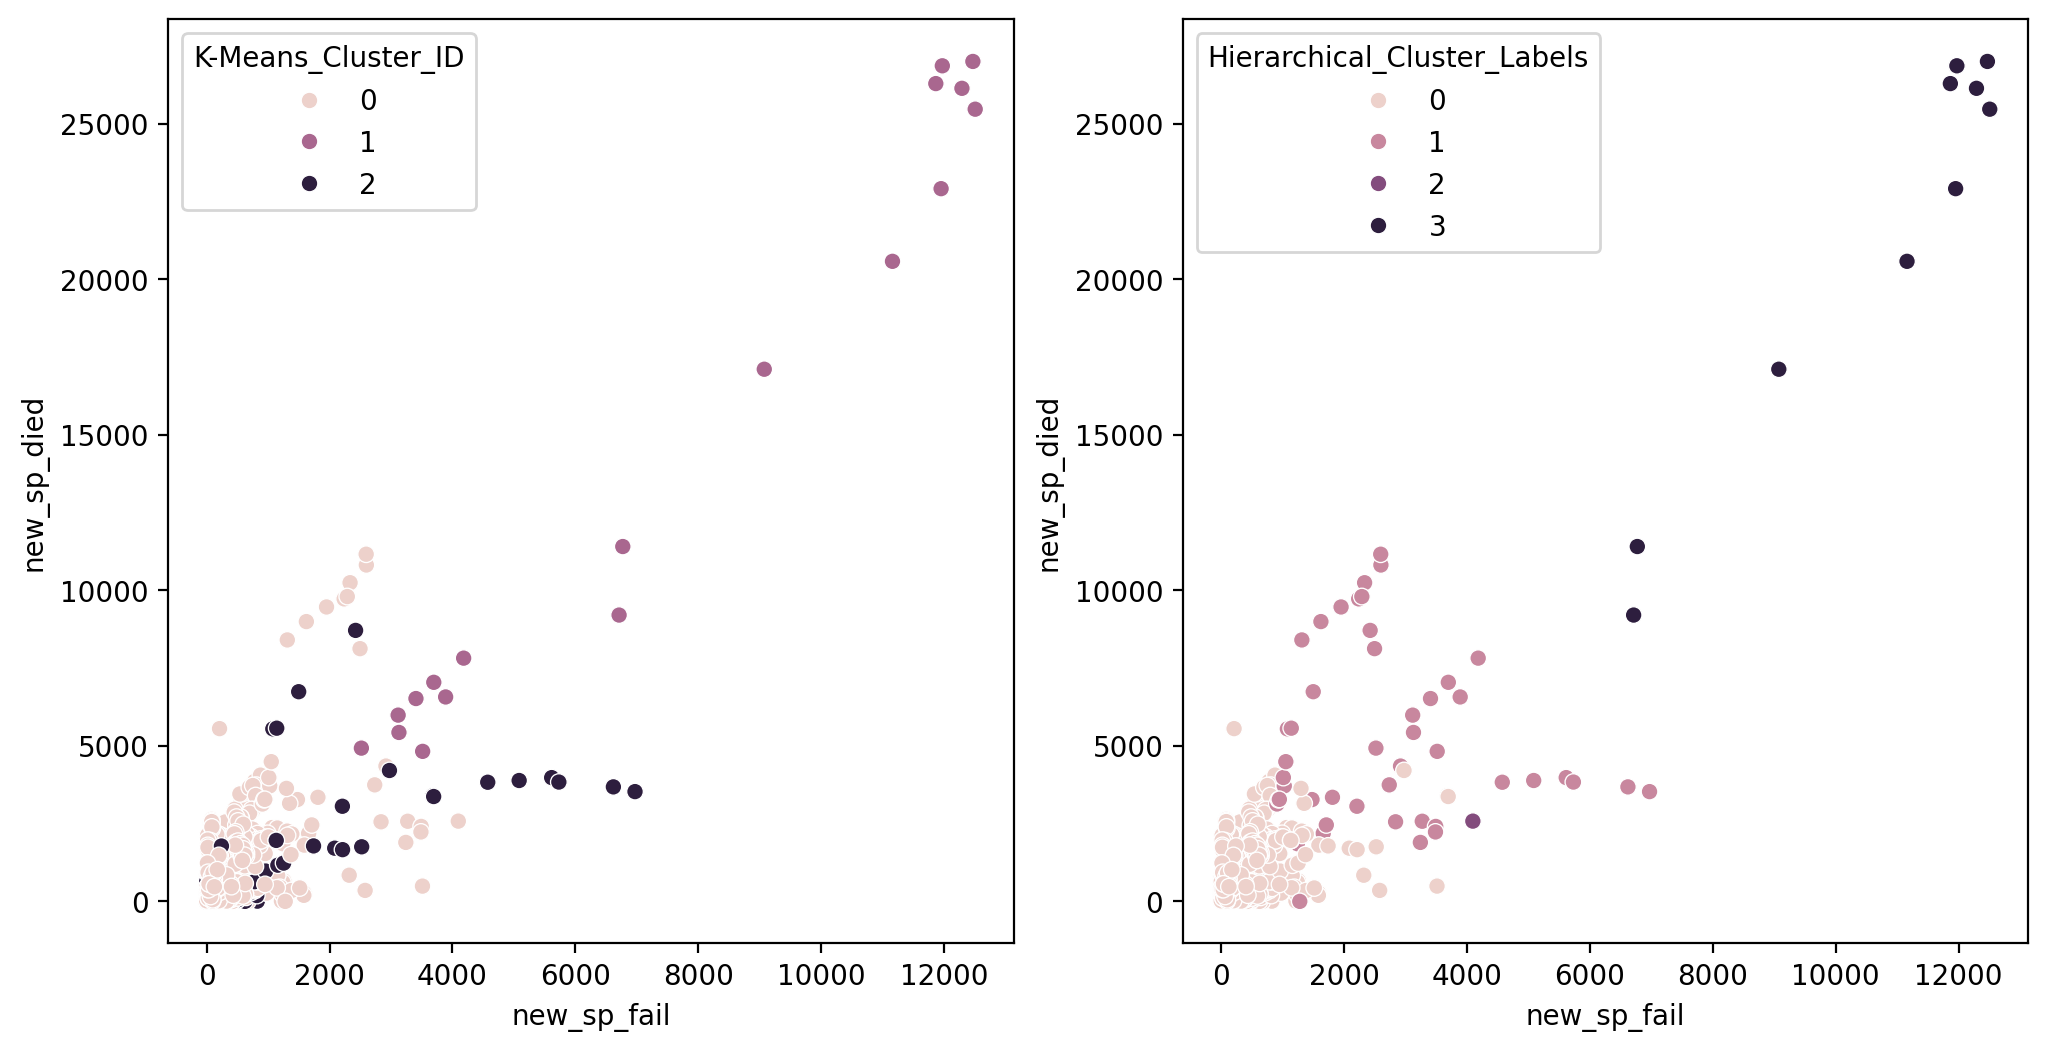

In [105]:
# Create a scatter plot using 'new_sp_fail' and 'new_sp_died' to visualize the cluster distribution

# Set up the figure and subplots
plt.figure(figsize=(12, 6), dpi=200)
plt.subplot(1, 2, 1)

# Scatter plot using KMeans cluster labels
sns.scatterplot(x='new_sp_fail', y='new_sp_died', data=df_cleaned, hue='K-Means_Cluster_ID')

# Set up the second subplot
plt.subplot(1, 2, 2)

# Scatter plot using hierarchical cluster labels
sns.scatterplot(x='new_sp_fail', y='new_sp_died', data=df_cleaned, hue='Hierarchical_Cluster_Labels')


Bayesian inference model using machine learning for predicting the treatment success rate from our dataset, I'll follow several steps. These steps involve preparing our data, selecting a model, and implementing the Bayesian approach. Given that I've narrowed down our dataset to the following columns:

COMPLETED:
- Step 1: Data Preparation
Clean the Data: Ensure that the data is clean, handling any missing or anomalous values.
Feature Engineering: From the existing columns, derive features that might be relevant for predicting the treatment success rate. This could involve calculating the proportion of cured cases out of the cohort size or the death rate, etc.
Normalization: Normalize or standardize your features so that they're on a similar scale. This is especially important for Bayesian models to ensure convergence.

ONGOING:
- Step 2: Model Selection
For Bayesian inference, you can use a variety of models, but a common choice is Bayesian Linear Regression if you're predicting a continuous outcome like the treatment success rate. This model allows you to incorporate prior beliefs about the parameters and update these beliefs based on the data.

- Step 3: Implementation
Define Priors: Based on your knowledge or assumptions about the treatment success rates, define prior distributions for the model parameters. For example, you might assume that the coefficients of your predictors in the linear model are normally distributed with mean 0 and some variance.
Model Building: Use a probabilistic programming language or a library like PyMC, Stan, or TensorFlow Probability to define your Bayesian model. You'll specify the likelihood of your data given the parameters (e.g., a normal distribution for the treatment success rates) and the prior distributions for these parameters.
Model Training: Run a Markov Chain Monte Carlo (MCMC) simulation or variational inference to estimate the posterior distributions of your model parameters. This process involves sampling from the posterior distributions to understand the probable values of your parameters given the data.
Prediction: Use the posterior distributions to make predictions about the treatment success rate. You can generate predictive distributions for new data points, which gives you not just an estimate but also a measure of uncertainty around this estimate.


In [106]:
# Extracting features (X) and target variable (y) from the DataFrame
X = data_scaled_df[['rep_meth', 'new_sp_coh', 'new_sp_cur', 'new_sp_cmplt', 'new_sp_died', 'new_sp_fail', 'new_sp_def', 'c_new_sp_tsr', 'c_ret_tsr']].values
y = data_scaled_df['c_new_tsr'].values


NOTE: THIS IS A SIMPLE MODEL (OUR FIRST ONE)

In [107]:
# Define a Bayesian regression model using PyMC3
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X, beta)

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample from the posterior using Markov chain Monte Carlo (MCMC)
    trace = pm.sample(1000, return_inferencedata=True)


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    0.000  0.008  -0.014    0.013      0.000    0.000    2736.0   
beta[0]  0.219  0.008   0.204    0.234      0.000    0.000    2442.0   
beta[1] -0.033  0.031  -0.085    0.030      0.001    0.001     993.0   
beta[2]  0.037  0.028  -0.012    0.090      0.001    0.001     924.0   
beta[3] -0.036  0.011  -0.056   -0.015      0.000    0.000    1287.0   
beta[4]  0.010  0.021  -0.032    0.048      0.001    0.000    1485.0   
beta[5]  0.062  0.018   0.030    0.098      0.000    0.000    2164.0   
beta[6] -0.070  0.020  -0.107   -0.032      0.001    0.000    1463.0   
beta[7]  0.796  0.009   0.779    0.813      0.000    0.000    1776.0   
beta[8]  0.171  0.009   0.154    0.188      0.000    0.000    2083.0   
sigma    0.534  0.005   0.525    0.544      0.000    0.000    2926.0   

         ess_tail  r_hat  
alpha      1521.0   1.00  
beta[0]    1609.0   1.00  
beta[1]    1313.0   1.00  
beta[2]    1102.0   1.00  


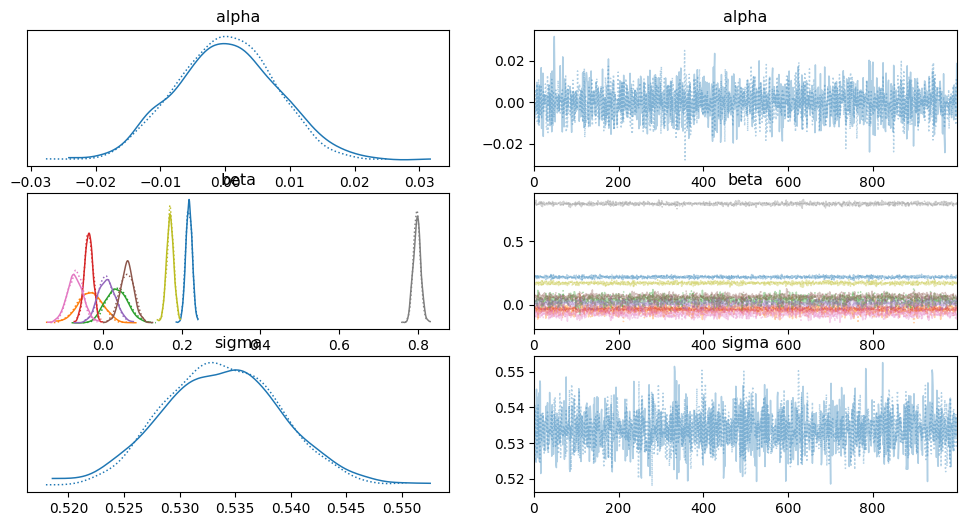

In [108]:
# Importing the arviz library for posterior analysis and visualization
import arviz as az

# Plotting the posterior distributions of the parameters using arviz
az.plot_trace(trace)

# Computing summary statistics for the posterior distributions
summary = az.summary(trace)

# Printing the summary statistics
print(summary)


These summary statistics provide information about the posterior distribution of each parameter in the Bayesian model. Each row corresponds to a parameter, and the columns represent various statistics such as the mean, standard deviation (SD), 3% and 97% Highest Density Intervals (HDI), Monte Carlo Standard Error (MCSE), Effective Sample Size (ESS), and Gelman-Rubin statistic (R-hat). These statistics are essential for assessing the convergence of the Markov Chain Monte Carlo (MCMC) sampling, estimating uncertainty, and diagnosing potential issues with the model.



- Parameter Estimates: The mean values for the parameters (alpha, beta[0] to beta[8], and sigma) provide estimates of the coefficients and variability in the model. These values represent the central tendency of the posterior distribution for each parameter.

- Uncertainty: The standard deviation (SD) provides a measure of uncertainty or variability around the mean estimate for each parameter. Larger standard deviations indicate greater uncertainty in the parameter estimates.

- Highest Density Intervals (HDI): The 3% and 97% HDI bounds provide credible intervals for each parameter. These intervals represent the range of values that contain the specified percentage (in this case, 94%) of the posterior distribution. They offer insights into the precision of the parameter estimates and help quantify uncertainty.

- Convergence: The Gelman-Rubin statistic (R-hat) assesses the convergence of the MCMC chains. A value close to 1 indicates that the chains have likely converged to the target distribution, suggesting good mixing and convergence.

- Effective Sample Size (ESS): The ESS measures the effective number of independent samples obtained from the MCMC chains. Higher ESS values indicate more efficient sampling and better estimation of the posterior distribution.

- Monte Carlo Standard Error (MCSE): The MCSE provides an estimate of the standard error for the mean estimate of each parameter. Lower MCSE values suggest more precise estimation.

- Overall Model Fit: These statistics collectively offer insights into the overall fit of the Bayesian model to the data. They help assess the reliability of the parameter estimates, the adequacy of the model in capturing the underlying patterns in the data, and the uncertainty associated with the estimates.

In [109]:
with model:
    # Generate posterior predictive samples
    post_pred = pm.sample_posterior_predictive(trace)

- Step 4: Evaluation and Interpretation
Evaluate the Model: Use appropriate metrics to evaluate the model's performance. Since you're dealing with a regression problem, metrics like RMSE (Root Mean Squared Error) or MAE (Mean Absolute Error) could be relevant.
Interpret the Results: Look at the posterior distributions of your parameters to understand the relationship between features and the treatment success rate. Bayesian inference also allows you to directly quantify the uncertainty in your predictions.



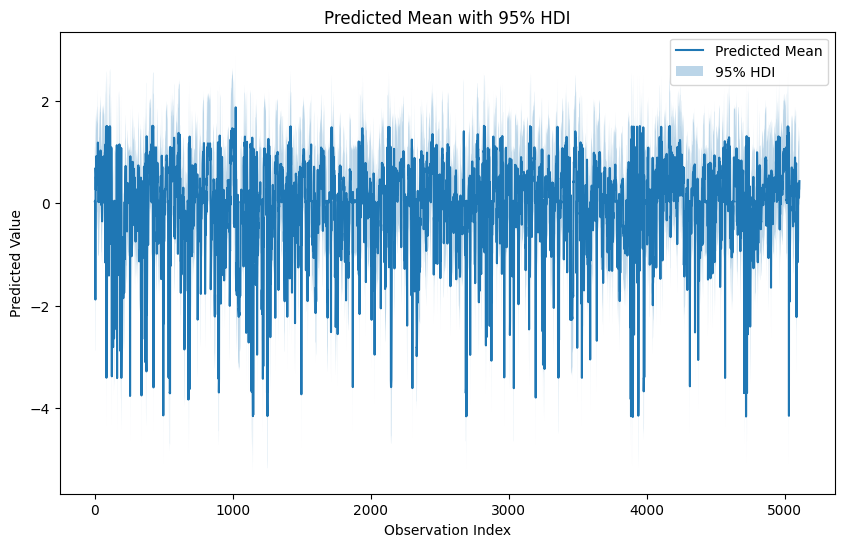

In [41]:
# Accessing the posterior_predictive group as an xarray.Dataset
post_pred = post_pred.posterior_predictive

# Accessing the y_obs variable within that dataset
y_obs_samples = post_pred.y_obs

# Calculate the Highest Density Interval (HDI)
hdi = az.hdi(y_obs_samples, hdi_prob=0.95)

# Calculating the mean prediction across all chains and draws for each observation
mean_prediction = y_obs_samples.mean(dim=['chain', 'draw']).values
# Extracting the lower and higher (upper) HDI bounds
lower_bound = hdi['y_obs'].sel(hdi='lower').values
upper_bound = hdi['y_obs'].sel(hdi='higher').values

# Now, plotting the HDI along with your data:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mean_prediction, label='Predicted Mean')
plt.fill_between(range(len(mean_prediction)), lower_bound, upper_bound, alpha=0.3, label='95% HDI')
plt.legend()
plt.title('Predicted Mean with 95% HDI')
plt.xlabel('Observation Index')
plt.ylabel('Predicted Value')
plt.show()





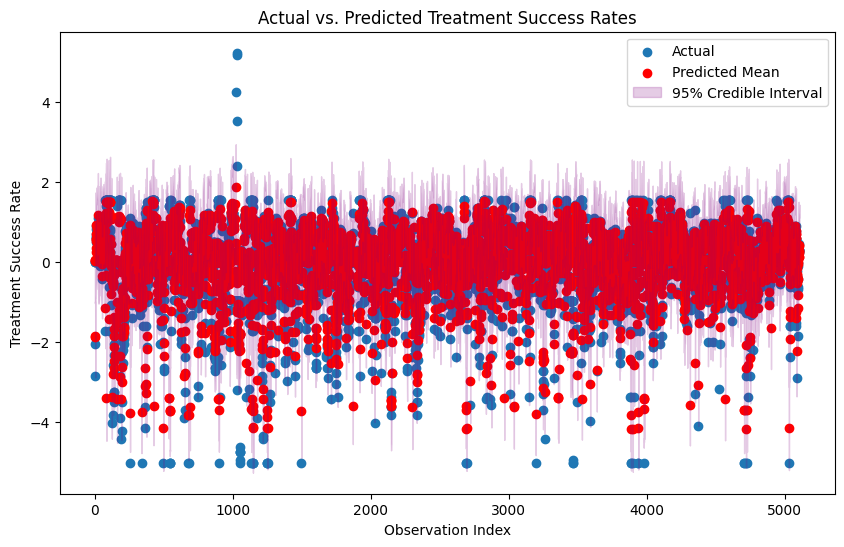

In [47]:
# Creating a figure for plotting with a specified size
plt.figure(figsize=(10, 6))

# Scatter plot for actual treatment success rates
plt.scatter(range(len(y)), y, label='Actual')

# Scatter plot for predicted mean treatment success rates
plt.scatter(range(len(mean_prediction)), mean_prediction, color='red', label='Predicted Mean')

# Filling the area between the actual and predicted mean with a 95% credible interval
plt.fill_between(range(len(y)), lower_bound, upper_bound, color='purple', alpha=0.2, label='95% Credible Interval')

# Adding legend and axis labels
plt.legend()
plt.xlabel('Observation Index')
plt.ylabel('Treatment Success Rate')
plt.title('Actual vs. Predicted Treatment Success Rates')

# Displaying the plot
plt.show()


In [61]:
# Calculate the mean and standard deviation across the 'draw' dimension for each observation
mean_prediction = post_pred['y_obs'].mean(dim='draw').values
std_prediction = post_pred['y_obs'].std(dim='draw').values



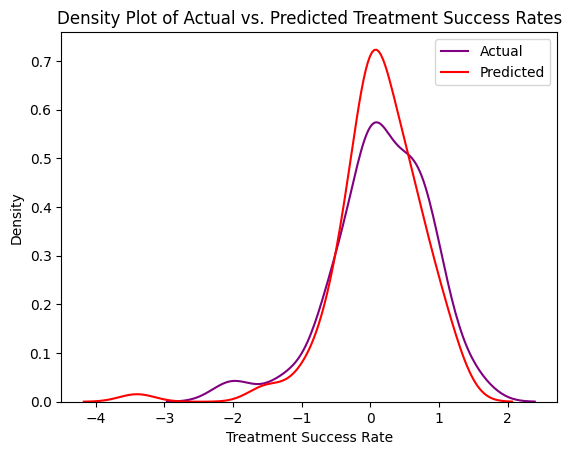

In [60]:
# Randomly select a subset of indices for visualization
subset_indices = np.random.choice(range(len(y)), size=100, replace=False)

# Kernel Density Estimation (KDE) plot for actual treatment success rates
sns.kdeplot(y[subset_indices], label='Actual', color='purple')

# Kernel Density Estimation (KDE) plot for predicted treatment success rates
sns.kdeplot(mean_prediction[subset_indices], label='Predicted', color='red')

# Adding axis labels and title
plt.xlabel('Treatment Success Rate')
plt.ylabel('Density')
plt.title('Density Plot of Actual vs. Predicted Treatment Success Rates')

# Displaying the legend and plot
plt.legend()
plt.show()


In [53]:
# Importing the mean_absolute_error function from sklearn.metrics
from sklearn.metrics import mean_absolute_error

# Calculating the Mean Absolute Error (MAE) between the actual and predicted treatment success rates
mae = mean_absolute_error(y, mean_prediction)

# Printing the calculated MAE
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.23718581083771825


In [54]:
# Importing the mean_squared_error function from sklearn.metrics
from sklearn.metrics import mean_squared_error

# Importing numpy library for mathematical operations
import numpy as np

# Calculating the Root Mean Squared Error (RMSE) between the actual and predicted treatment success rates
rmse = np.sqrt(mean_squared_error(y, mean_prediction))

# Printing the calculated RMSE
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 0.5333670476854695


In [55]:
# Importing the r2_score function from sklearn.metrics
from sklearn.metrics import r2_score

# Calculating the R-squared (coefficient of determination) between the actual and predicted treatment success rates
r2 = r2_score(y, mean_prediction)

# Printing the calculated R-squared
print(f"R-squared: {r2}")


R-squared: 0.7155195924432861


In [58]:
# Calculate the coverage probability of the credible interval
coverage = np.mean((mean_prediction >= lower_bound) & (mean_prediction <= upper_bound))

# Print the calculated coverage probability
print(f"Credible Interval Coverage: {coverage * 100}%")


Credible Interval Coverage: 100.0%


In [59]:
# Calculate the average width of the prediction interval
pi_width = np.mean(upper_bound - lower_bound)

# Print the calculated average width of the prediction interval
print(f"Average Prediction Interval Width: {pi_width}")


Average Prediction Interval Width: 2.0766515239113383


...SOME PLOTS

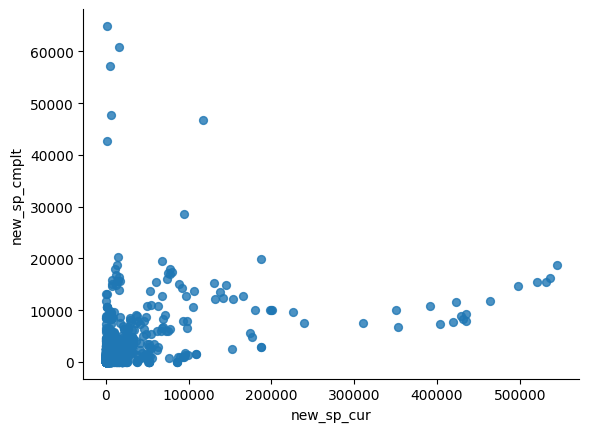

In [ ]:
# @title new_sp_cur vs new_sp_cmplt  cured vs completed

from matplotlib import pyplot as plt
df_cleaned.plot(kind='scatter', x='new_sp_cur', y='new_sp_cmplt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

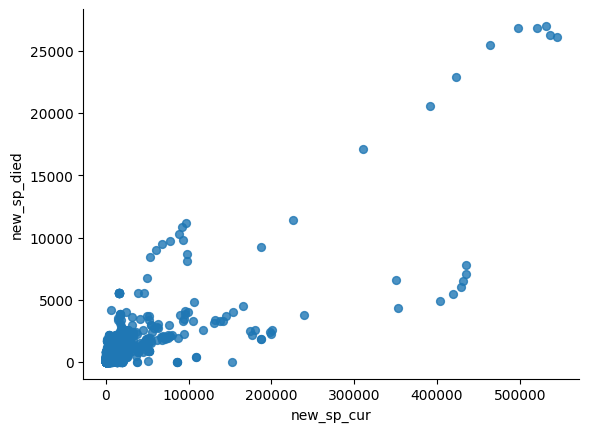

In [ ]:
# @title new_sp_cur vs new_sp_died  cured vs died

from matplotlib import pyplot as plt
df_cleaned.plot(kind='scatter', x='new_sp_cur', y='new_sp_died', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

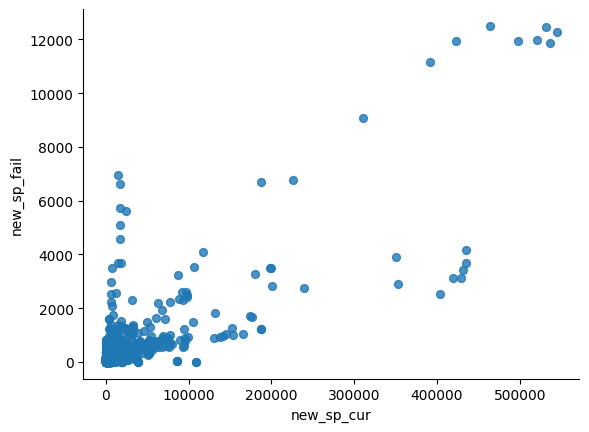

In [ ]:
# @title new_sp_cur vs new_sp_fail  cured vs failed

from matplotlib import pyplot as plt
df_cleaned.plot(kind='scatter', x='new_sp_cur', y='new_sp_fail', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

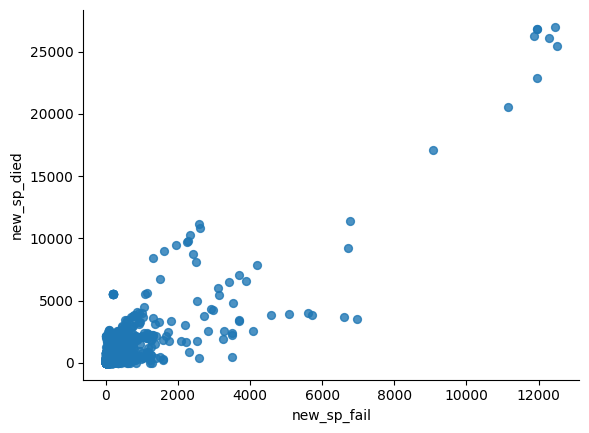

In [ ]:
# @title new_sp_fail vs new_sp_died  failed vs died

from matplotlib import pyplot as plt
df_cleaned.plot(kind='scatter', x='new_sp_fail', y='new_sp_died', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)